# Coursera Capstone - Weeks 4-5

## Start off by importing libraries

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!pip install bs4 
!pip install lxml

#ALREADY INSTALLED FORGE USING ANACONDA PROMPT
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#ALREADY INSTALLED FOLIUM USING ANACONDA PROMPT
!conda install -c conda-forge folium=0.5.0 #--yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

     |████████████████████████████████| 102kB 16.0MB/s ta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
     |████████████████████████████████| 5.8MB 30.5MB/s eta 0:00:01
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ------------------------------------------------------------
                               

In [2]:
#web scraping using pandas
#note: set header = 0 to use the first row as column headers
# !pip install lxml to correct import error when reading html, lxml was not found
#!pip install html5lib #bandaid for lxml
!conda install -c conda-forge lxml --yes #-c conda-forge geopy --yes 
!conda install -c conda-forge html5lib --yes #-c conda-forge geopy --yes 

d = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M', header=0)

#Interesting notes about the pandas list of tables that's created from reading the URL
#type(d) #prints 'list'
#print(len(d)) #prints '3' since there are 3 tables on this page. the one we want to use is index=0
#print(d[0]) #
#format of df['column_name']['row_#_in_column_name']

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - lxml


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    lxml-4.4.1                 |   py36h7ec2d77_0         1.6 MB  conda-forge

The following packages will be UPDATED:

    lxml: 4.2.5-py37hefd8a0e_0 --> 4.4.1-py36h7ec2d77_0 conda-forge


lxml-4.4.1           | 1.6 MB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ cond

### Extract the table from the URL as a Pandas dataframe (note the shape and column names)

In [3]:
#set the target table to a 'dataframe'
df = d[0]

#check the shape of df
print(len(df)) #prints '289' is the # of rows (including the column name row)
print(df.shape) #prints '(289, 3)'
print(df.columns) #prints 'Index(['Postcode', 'Borough', 'Neighbourhood'], dtype='object')'

288
(288, 3)
Index(['Postcode', 'Borough', 'Neighbourhood'], dtype='object')


### Remove rows in the Borough column that are 'Not assigned' (and view the results)

In [4]:
#remove Postcodes that are "Not Assigned"
#df = df.drop(df[df.score < 50].index)
df_del_na = df.drop(df[df.Borough == 'Not assigned'].index)
df_del_na.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


### Set Neighborhood from 'Not assigned' to "Queen's Park" (and view the results)

In [5]:
#set Neighborhood from 'Not assigned' to "Queen's Park"
df_del_na.loc[df_del_na['Neighbourhood'] == "Not assigned", 'Neighbourhood'] = "Queen's Park"
df_del_na.head(10)

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Queen's Park
10,M9A,Etobicoke,Islington Avenue
11,M1B,Scarborough,Rouge
12,M1B,Scarborough,Malvern


### Rename column name from 'Neighbourhood' to 'Neighborhood'

In [6]:
df_del_na.rename(columns={'Postcode': 'PostalCode', 'Neighbourhood': 'Neighborhood'}, inplace=True)
df_del_na.head()

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


### Flatten the table (for the rows in the Neighborhood columns)

In [7]:
#flatten groupby results by setting Neighborhood to list per row
#ORIGINAL SCRIPT--->>>> df_del_na_grouped_flat = df_del_na.groupby(['PostalCode', 'Borough'])['Neighborhood'].apply(lambda group_series: group_series.tolist()).reset_index()

df_del_na_grouped_flat = df_del_na.groupby(['PostalCode', 'Borough'])['Neighborhood'].apply(list).apply(lambda x:', '.join(x)).to_frame().reset_index() #CHANGED SOLUTION TO EXAMPLE FROM ANOTHER STUDENT 
print(df_del_na_grouped_flat.head(10), '\n', '\n')
print(df_del_na_grouped_flat.tail(10))

#ORIGINAL PRINT COMMANDS BELOW
#print(df_del_na_grouped_flat.head(10), '\n', '\n')
#print(df_del_na_grouped_flat.tail(10))

  PostalCode      Borough                                     Neighborhood
0        M1B  Scarborough                                   Rouge, Malvern
1        M1C  Scarborough           Highland Creek, Rouge Hill, Port Union
2        M1E  Scarborough                Guildwood, Morningside, West Hill
3        M1G  Scarborough                                           Woburn
4        M1H  Scarborough                                        Cedarbrae
5        M1J  Scarborough                              Scarborough Village
6        M1K  Scarborough      East Birchmount Park, Ionview, Kennedy Park
7        M1L  Scarborough                  Clairlea, Golden Mile, Oakridge
8        M1M  Scarborough  Cliffcrest, Cliffside, Scarborough Village West
9        M1N  Scarborough                      Birch Cliff, Cliffside West 
 

    PostalCode     Borough                                       Neighborhood
93         M9A   Etobicoke                                   Islington Avenue
94         M9B 

### Read the csv into a pandas dataframe

In [8]:
geofile = pd.read_csv('https://cocl.us/Geospatial_data')

### Rename the Postal Code column to PostalCode

In [9]:
geofile.rename(columns = {'Postal Code': 'PostalCode'}, inplace=True)

### Merge the two dataframes

In [10]:
df_combined = pd.merge(df_del_na_grouped_flat, geofile, how='left', on='PostalCode')

### View the merged dataframe

In [11]:
df_combined.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [12]:
df_combined.shape

(103, 5)

### Plot the Neighborhoods

In [13]:
#Use a starting latitude and longitude to help center the Toronto area map:
latitude = 43.72
longitude = -79.4
venues_map = folium.Map(location=[latitude, longitude], zoom_start=11.5) # generate map centred around the Conrad Hotel

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(df_combined.Latitude, df_combined.Longitude, df_combined.PostalCode):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

#### Define Foursquare ID and Secret (hidden for GIT post)

In [14]:
CLIENT_ID = 'HBIWSY1J1OXYRJV3GRFGMHIKD25MSPBZJSDBWVVQBEWM1YGB' # your Foursquare ID
CLIENT_SECRET = 'UBNOMB4NFKZWJU21DBEDHRHPFZEFNSPMK0RT2YFOV4DDN4BL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HBIWSY1J1OXYRJV3GRFGMHIKD25MSPBZJSDBWVVQBEWM1YGB
CLIENT_SECRET:UBNOMB4NFKZWJU21DBEDHRHPFZEFNSPMK0RT2YFOV4DDN4BL


#### Define Foursquare Credentials and Version

In [15]:
def getNearbyVenues(postalcodes, names, latitudes, longitudes, radius=500, LIMIT=100): #added ratings
    
    venues_list=[]
    for postalcode, name, lat, lng in zip(postalcodes, names, latitudes, longitudes): #added ratings
        print(name)
            
        # create the API request URL #need to add ratings query to this url request
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,            
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            postalcode,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode',
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Use the function that explores nearby venues

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *toronto_venues*.

In [16]:
toronto_venues = getNearbyVenues(postalcodes=df_combined['PostalCode'],
                                 names=df_combined['Neighborhood'],
                                   latitudes=df_combined['Latitude'],
                                   longitudes=df_combined['Longitude']
                                  )



Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

#### Let's peek at sample rows and the shape of the Toronto venues dataframe

In [17]:
toronto_venues.sample(10)

,PostalCode,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1719,M5W,Stn A PO Boxes 25 The Esplanade,43.646435,-79.374846,Over Easy,43.648077,-79.377599,Breakfast Spot
544,M4W,Rosedale,43.679563,-79.377529,Milkman's Lane,43.676352,-79.373842,Trail
1885,M6E,Caledonia-Fairbanks,43.689026,-79.453512,Walmart,43.690660,-79.456317,Market
113,M2J,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,TD Canada Trust,43.777763,-79.345974,Bank
735,M5B,"Ryerson, Garden District",43.657162,-79.378937,Tacos 101,43.656636,-79.376968,Taco Place
1585,M5T,"Chinatown, Grange Park, Kensington Market",43.653206,-79.400049,Krudar Muay Thai,43.652815,-79.401368,Martial Arts Dojo
2067,M6S,"Runnymede, Swansea",43.651571,-79.484450,Campo,43.655191,-79.487067,Italian Restaurant
25,M1K,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029,Hakka No.1,43.727688,-79.266057,Chinese Restaurant
1854,M5X,"First Canadian Place, Underground city",43.648429,-79.382280,Library Bar,43.645500,-79.381602,Hotel Bar
1974,M6J,"Little Portugal, Trinity",43.647927,-79.419750,Trinity Bellwoods Dog Park - The Bowl,43.648625,-79.414443,Dog Run


In [18]:
#export combined dataframe to excel (optional)
#!conda install -c conda-forge openpyxl --yes

#toronto_venues.to_excel("toronto_venues.xlsx")

In [19]:
toronto_venues.shape

(2244, 8)

#### Sample the types of categories and print the total venue categories in the Toronta area

In [20]:
df_toronto = pd.DataFrame(toronto_venues.groupby('Venue Category')['Venue Category'].count()) #count() :['count'] #agg({'Count':['count']})
df_toronto.rename(columns={'Venue Category': 'Count'}, inplace=True)
df_toronto.sample(10)

,Count
Venue Category,
Flower Shop,2
Comic Shop,3
Dog Run,6
Gastropub,24
Historic Site,1
Speakeasy,5
Housing Development,1
Ice Cream Shop,21
Fraternity House,1


In [21]:
print("There are {} categories of venues in the Toronto area.".format(df_toronto.shape[0]))

There are 280 categories of venues in the Toronto area.


#### Start with one hot encoding

In [22]:
# one hot encoding
toronto_venues_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add latitudes for both Neighborhoods and Venues back to dataframe - for adding lat, long later
#toronto_venues_onehot_lat-lon[['Neighborhood Latitude', 'Neighborhood Longitude']] = toronto_venues[['Neighborhood Latitude', 'Neighborhood Longitude']]
#toronto_venues_onehot_lat-lon[['Venue Latitude', 'Venue Longitude']] = toronto_venues[['Venue Latitude', 'Venue Longitude']]

# add PostalCode column back to dataframe
toronto_venues_onehot['PostalCode'] = toronto_venues['PostalCode'] 

# move postal code column to the first column
fixed_columns = [toronto_venues_onehot.columns[-1]] + list(toronto_venues_onehot.columns[:-1])
toronto_venues_onehot = toronto_venues_onehot[fixed_columns]

toronto_venues_onehot.head()

,PostalCode,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's S

In [23]:
toronto_venues_onehot.shape

(2244, 281)

~~REMOVE THIS FOR FINAL VERSION *** EITHER SCALE LAT, LON OR REMOVE LAT, LON ALTOGETHER~~

In [24]:
#toronto_venues_onehot_grouped_temp = toronto_venues_onehot.groupby('PostalCode').mean().reset_index()
#toronto_venues_onehot_grouped_temp.head(5)

~~REMOVE THIS FOR FINAL VERSION 
Now let's normalize the dataset. But why do we need normalization in the first place? Normalization is a statistical method that helps mathematical-based algorithms interpret features with different magnitudes and distributions equally. We use **StandardScaler()** to normalize our dataset.~~

In [25]:
#MIGHT NOT HAVE TO SCALE SINCE AVERAGES - THIS IS FROM 3-3-1
#from sklearn.preprocessing import StandardScaler

#add step to remove postalcode
#X = toronto_venues_onehot_grouped_temp.values[:,1:] #<-Change df name to toronto_venues_onehot or toronto_venues
#X = np.nan_to_num(X)
#toronto_venues_onehot_grouped_temp_scale = StandardScaler().fit_transform(X)
#toronto_venues_onehot_grouped_temp_scale

#### Next, let's group rows by Postal Code and by taking the mean of the frequency of occurrence of each category

In [26]:
toronto_venues_onehot_grouped = toronto_venues_onehot.groupby('PostalCode').mean().reset_index()
toronto_venues_onehot_grouped.sample(5)

,PostalCode,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's S

#### Let's confirm the new size

In [27]:
toronto_venues_onehot_grouped.shape

(101, 281)

In [28]:
toronto_venues_onehot_grouped['PostalCode'].unique()

array(['M1B', 'M1C', 'M1E', 'M1G', 'M1H', 'M1J', 'M1K', 'M1L', 'M1M',
       'M1N', 'M1P', 'M1R', 'M1S', 'M1T', 'M1V', 'M1W', 'M2H', 'M2J',
       'M2K', 'M2L', 'M2M', 'M2N', 'M2P', 'M2R', 'M3A', 'M3B', 'M3C',
       'M3H', 'M3J', 'M3K', 'M3L', 'M3M', 'M3N', 'M4A', 'M4B', 'M4C',
       'M4E', 'M4G', 'M4H', 'M4J', 'M4K', 'M4L', 'M4M', 'M4N', 'M4P',
       'M4R', 'M4S', 'M4T', 'M4V', 'M4W', 'M4X', 'M4Y', 'M5A', 'M5B',
       'M5C', 'M5E', 'M5G', 'M5H', 'M5J', 'M5K', 'M5L', 'M5M', 'M5N',
       'M5P', 'M5R', 'M5S', 'M5T', 'M5V', 'M5W', 'M5X', 'M6A', 'M6B',
       'M6C', 'M6E', 'M6G', 'M6H', 'M6J', 'M6K', 'M6L', 'M6M', 'M6N',
       'M6P', 'M6R', 'M6S', 'M7A', 'M7R', 'M7Y', 'M8V', 'M8W', 'M8X',
       'M8Y', 'M8Z', 'M9B', 'M9C', 'M9L', 'M9M', 'M9N', 'M9P', 'M9R',
       'M9V', 'M9W'], dtype=object)

In [29]:
toronto_venues_onehot_grouped['PostalCode'].nunique()

101

#### Let's do k-means for all venues

#### Remove categorical columns 
Remove categorical columns in order to perform k-means labeling and clustering

In [30]:
toronto_venues_onehot_grouped_clustering = toronto_venues_onehot_grouped.drop('PostalCode', 1)

In [31]:
toronto_venues_onehot_grouped_clustering.shape

(101, 280)

#### "Elbow" Plot Analysis
The Elbow method analyzes the number of k-means clusters (k) by plotting and examining the sum of squared distances from the cluster center (SSD) for a given number of clusters (k). When plotted, we can visually identify the optimal number of clusters, which should clearly show a point on the graph where reduction in SSE diminishes for increases in k. This point is referred to as the "elbow."

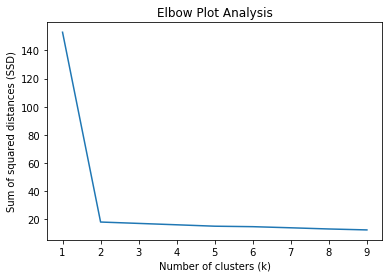

In [47]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 

ssd = {}
for k in range(1, 10):
    kmeans_elbow = KMeans(n_clusters=k, max_iter=1000).fit(toronto_venues_onehot_grouped_clustering)
    toronto_venues_onehot_grouped_clustering["clusters"] = kmeans_elbow.labels_
    #print(toronto_venues_onehot_grouped_clustering["clusters"])
    ssd[k] = kmeans_elbow.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure() #.pyplot
plt.plot(list(ssd.keys()), list(ssd.values()))
plt.title("Elbow Plot Analysis")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Sum of squared distances (SSD)")
plt.show()

#### In the figure above, the optimal number number of clusters, k, is 2

In [33]:
# set number of clusters based on the elbow plot
kclusters = 2

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_venues_onehot_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[:] #commented this one out until get len of rows (probably from shape)

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0], dtype=int32)

In [34]:
#add labels column to toronto dataframe
labels = kmeans.labels_
toronto_venues_onehot_grouped['Cluster Labels'] = labels
toronto_venues_onehot_grouped.head()

,PostalCode,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's S

In [35]:
toronto_venues_onehot_grouped.shape

(101, 282)

In [36]:
# refresh my memory on columuns/structure of toronto_venues
toronto_venues.head()

,PostalCode,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M1B,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,M1C,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
3,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant


In [37]:
#groupby toronto venues to later add latitudes, longitudes to onehot dataframe
toronto_venues.groupby('PostalCode').mean().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude
PostalCode,,,,
M1B,43.806686,-79.194353,43.807448,-79.199056
M1C,43.784535,-79.160497,43.782533,-79.163085
M1E,43.763573,-79.188711,43.766502,-79.191117
M1G,43.770992,-79.216917,43.770559,-79.219579
M1H,43.773136,-79.239476,43.774893,-79.240162


In [38]:
#confirm the shape / number of rows for PostalCode join
toronto_venues.groupby('PostalCode').mean().shape

(101, 4)

In [39]:
#add kmeans labels to grouped toronto labels...STILL RESET INDEX INPLACE?
df_temp = toronto_venues.groupby(['PostalCode', 'Neighborhood']).mean().reset_index() 

In [40]:
type(df_temp) #DataFrame check. reset_index removes df type?? #DELETE THIS CELL AFTER TEST WORKS

pandas.core.frame.DataFrame

In [41]:
df_temp.head()

,PostalCode,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude
0,M1B,"Rouge, Malvern",43.806686,-79.194353,43.807448,-79.199056
1,M1C,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,43.782533,-79.163085
2,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,43.766502,-79.191117
3,M1G,Woburn,43.770992,-79.216917,43.770559,-79.219579
4,M1H,Cedarbrae,43.773136,-79.239476,43.774893,-79.240162


In [42]:
df_labels_temp = toronto_venues_onehot_grouped[['PostalCode', 'Cluster Labels']] #, 'Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'

In [43]:
df_labels_temp.head()

,PostalCode,Cluster Labels
0,M1B,0
1,M1C,1
2,M1E,0
3,M1G,0
4,M1H,0


In [44]:
toronto_venues_groupby_AddKmeansLabels = pd.merge(df_temp, df_labels_temp, how='left', on='PostalCode') #.reset.index(inplace=True) #CHECK MERGE METHOD...NEIGHBORHOOD STILL LEFT OFF (BETTER THAN ERROR THIS TIME)

In [45]:
toronto_venues_groupby_AddKmeansLabels.head() #great, but still needs Neighborhood

,PostalCode,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Cluster Labels
0,M1B,"Rouge, Malvern",43.806686,-79.194353,43.807448,-79.199056,0
1,M1C,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,43.782533,-79.163085,1
2,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,43.766502,-79.191117,0
3,M1G,Woburn,43.770992,-79.216917,43.770559,-79.219579,0
4,M1H,Cedarbrae,43.773136,-79.239476,43.774893,-79.240162,0


#### Now that we've added the k-means cluster labels, let's perform a groupby query by the **_Cluster Labels_** column

In [51]:
toronto_venues_groupby_AddKmeansLabels.groupby(['Cluster Labels', 'Neighborhood']).mean()

Neighborhood Latitude  \
Cluster Labels Neighborhood                                                                
0              Adelaide, King, Richmond                                        43.650571   
               Agincourt                                                       43.794200   
               Albion Gardens, Beaumond Heights, Humbergate, J...              43.739416   
               Alderwood, Long Branch                                          43.602414   
               Bathurst Manor, Downsview North, Wilson Heights                 43.754328   
               Bayview Village                                                 43.786947   
               Bedford Park, Lawrence Manor East                               43.733282   
               Berczy Park                                                     43.644771   
               Birch Cliff, Cliffside West                                     43.692657   
               Bloordale Gardens, Eringate, Markland Wood, Old...              43.643515   
               Brockton, Exhibition Place, Parkdale Village                    43.636847   
               Business Reply Mail Processing Centre 969 Eastern               43.662744   
               CN Tower, Bathurst Quay, Island airport, Harbou...              43.628947   
               Cabbagetown, St. James Town                                     43.667967   
               Canada Post Gateway Processing Centre                           43.636966   
               Cedarbrae                                                       43.773136   
               Central Bay Street                                              43.657952   
               Chinatown, Grange Park, Kensington Market                       43.653206   
               Christie                                                        43.669542   
               Church and Wellesley                                            43.665860   
               Clairlea, Golden Mile, Oakridge                                 43.711112   
               Clarks Corners, Sullivan, Tam O'Shanter                         43.781637   
               Cliffcrest, Cliffside, Scarborough Village West                 43.716316   
               Commerce Court, Victoria Hotel                                  43.648199   
               Davisville                                                      43.704324   
               Davisville North                                                43.712751   
               Deer Park, Forest Hill SE, Rathnelly, South Hil...              43.686412   
               Del Ray, Keelesdale, Mount Dennis, Silverthorn                  43.691116   
               Design Exchange, Toronto Dominion Centre                        43.647177   
               Don Mills North                                                 43.745906   
               Dorset Park, Scarborough Town Centre, Wexford H...              43.757410   
               Dovercourt Village, Dufferin                                    43.669005   
               Downsview Central                                               43.728496   
               Downsview Northwest                                             43.761631   
               Downsview West                                                  43.739015   
               Downsview, North Park, Upwood Park                              43.713756   
               East Birchmount Park, Ionview, Kennedy Park                     43.727929   
               Emery, Humberlea                                                43.724766   
               Fairview, Henry Farm, Oriole                                    43.778517   
               First Canadian Place, Underground city                          43.648429   
               Flemingdon Park, Don Mills South                                43.725900   
               Forest Hill North, Forest Hill West                             43.696948   
               Glen

In [46]:
#merge latitude, longitude
#manhattan_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
#manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')


#### Visualize the Clusters (inserted from lesson 3-3-2)

In [58]:
# create map
latitude = 43.72
longitude = -79.4

map_clusters_2 = folium.Map(location=[latitude, longitude], zoom_start=11.5)

# set color scheme for the clusters
x = np.arange(kclusters) #kclusters already identified during the "elbow" analysis
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_venues_groupby_AddKmeansLabels['Neighborhood Latitude'], toronto_venues_groupby_AddKmeansLabels['Neighborhood Longitude'], toronto_venues_groupby_AddKmeansLabels['PostalCode'], toronto_venues_groupby_AddKmeansLabels['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_2)
       
map_clusters_2

#### Next steps:
  * Check venue categories for labels 0 and 1 to look for trend
  * Also (on labels topic) look at >0 mean venues similar to end of 3-3-2
  * *-->>IN PROGRESS Found article on Toronto crime. Show the cluster "elbow." Check notes for number of cluster table
  * perform (kmeans, DBScan, HBScan)
  * DBScan clustering - python notes?? 
  * HBSCAN clustering using  (maybe )
  * Consider having a list of inspirational articles (links)
  **DONE - use 3-3-2 for onehot.groupby('Neighborhood').mean().reset_index(). show avgs but be aware of counts.  
  * DONE - Plot the labels, clusters
  * DONE - then have to merge labels with original df (join on postal code)
  * DONE - kmeans clustering - start from pre-processing section of DP0701EN-3-3-1-Clustering-k-means-py-v1.0. do one-hot analysis
  * DONE - copy p3 until analyze number of venues. keep all venues in and plot clusters for neighborhoods 
  * DONE - get list of categories
  * DONE - download data from Foursquare
  * DONE / CHECKED - after onehot, show frequencies of venues?
  * NOTED - get avgs beware of low counts for  groupby on clusters (for categories, venues)
  * CNCL - get ratings of venues/categories - might not need
  * CNCL - determine good/neutral/bad categories - assign point ratings
  * N/A - Read Amherst list of great areas


In [ ]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [ ]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [44]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,4,Sandwich Place,Discount Store,Coffee Shop,Yoga Studio,Clothing Store,Supplement Shop,Gym,Donut Shop,Shopping Mall,Steakhouse
1,Manhattan,Chinatown,40.715618,-73.994279,1,Chinese Restaurant,Cocktail Bar,American Restaurant,Vietnamese Restaurant,Salon / Barbershop,Bakery,Bubble Tea Shop,Spa,Dumpling Restaurant,Ice Cream Shop
2,Manhattan,Washington Heights,40.851903,-73.936900,4,Café,Mobile Phone Shop,Bakery,Grocery Store,Coffee Shop,Mexican Restaurant,Liquor Store,Latin American Restaurant,New American Restaurant,Park
3,Manhattan,Inwood,40.867684,-73.921210,4,Mexican Restaurant,Café,Lounge,Pizza Place,Park,Bakery,Caribbean Restaurant,Chinese Restaurant,Restaurant,Frozen Yogurt Shop
4,Manhattan,Hamilton Heights,40.823604,-73.949688,4,Coffee Shop,Mexican Restaurant,Pizza Place,Café,Yoga Studio,Indian Restaurant,Sushi Restaurant,Sandwich Place,Deli / Bodega,Liquor Store
